# MCTS Step-by-Step Walkthrough

This notebook provides an interactive walkthrough of Monte Carlo Tree Search (MCTS) applied to retrosynthesis. We'll run 10 iterations on a simple molecule and examine each phase in detail:

1. **Selection** - Traversing the tree using UCB1 to find a leaf node
2. **Expansion** - Generating child nodes via DORAnet fragmentation
3. **Rollout** - Evaluating nodes using reward/rollout policies
4. **Backpropagation** - Updating values along the path to root

## Table of Contents
1. [Introduction & Setup](#1-introduction--setup)
2. [The MCTS Loop Explained](#2-the-mcts-loop-explained)
3. [Iteration-by-Iteration Walkthrough](#3-iteration-by-iteration-walkthrough)
4. [Final Analysis](#4-final-analysis)

---

## 1. Introduction & Setup

In [1]:
import os
import sys
from pathlib import Path
import math
from typing import List, Optional, Dict, Any, Tuple
from dataclasses import dataclass

# Add the repository root to the path
REPO_ROOT = Path.cwd().parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Silence RDKit warnings for cleaner output
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

# Core imports
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# Import DORAnet MCTS components
from DORAnet_agent import DORAnetMCTS
from DORAnet_agent.node import Node

print("Setup complete!")

/Users/yashchainani/Desktop/PythonProjects/RetroTideV2/bcs/bcs.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


































































































































































































































































































































["AT{'substrate': 'allylmal'}", "KR{'type': 'C1'}", 'loading: False']
["AT{'substrate': 'hexmal'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'butmal'}", "KR{'type': 'B2'}", 'loading: False']
["AT{'substrate': 'mxmal'}", "KR{'type': 'C1'}", 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'B2'}", 'loading: False']
["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'C1'}", 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'C2'}", 'loading: False']
["AT{'subs

### Define Target Molecule

We'll use **pentanoic acid** (`CCCCC(=O)O`) as our target - it's simple enough to expand quickly but complex enough to demonstrate the MCTS process.

Target: Pentanoic acid
SMILES: O=C(O1)C=C(OC)CC1CCC2=CC=CC=C2
Formula: C5H10O2
MW: 232.28 g/mol


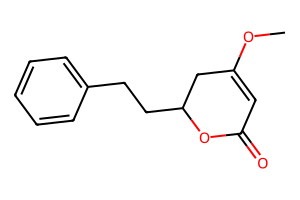

In [2]:
# Define target molecule
TARGET_SMILES = "O=C(O1)C=C(OC)CC1CCC2=CC=CC=C2"  # Pentanoic acid (valeric acid)
target_molecule = Chem.MolFromSmiles(TARGET_SMILES)

print(f"Target: Pentanoic acid")
print(f"SMILES: {TARGET_SMILES}")
print(f"Formula: C5H10O2")
print(f"MW: {Descriptors.MolWt(target_molecule):.2f} g/mol")

# Visualize
display(Draw.MolToImage(target_molecule, size=(300, 200)))

### Configure MCTS Parameters

We'll use minimal settings to keep the walkthrough clear and focused.

In [3]:
# MCTS Configuration
MCTS_CONFIG = {
    "total_iterations": 10,
    "max_depth": 3,
    "max_children_per_expand": 5,
    "MW_multiple_to_exclude": 2.0,
    "selection_policy": "UCB1",  # Standard UCB1 (easier to explain than depth_biased)
    "use_enzymatic": True,
    "use_synthetic": True,
    "spawn_retrotide": False,  # Disable RetroTide for simpler walkthrough
}

print("MCTS Configuration:")
for key, value in MCTS_CONFIG.items():
    print(f"  {key}: {value}")

MCTS Configuration:
  total_iterations: 10
  max_depth: 3
  max_children_per_expand: 5
  MW_multiple_to_exclude: 2.0
  selection_policy: UCB1
  use_enzymatic: True
  use_synthetic: True
  spawn_retrotide: False


---

## 2. The MCTS Loop Explained

Monte Carlo Tree Search builds a search tree incrementally through four phases:

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                           MCTS ITERATION LOOP                                    │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                  │
│   ┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌────────────┐ │
│   │  SELECTION   │ --> │  EXPANSION   │ --> │   ROLLOUT    │ --> │ BACKPROP   │ │
│   │              │     │              │     │              │     │            │ │
│   │ Traverse tree│     │ Generate     │     │ Evaluate     │     │ Update     │ │
│   │ using UCB1   │     │ children via │     │ terminal     │     │ values up  │ │
│   │ to find leaf │     │ DORAnet      │     │ nodes        │     │ to root    │ │
│   └──────────────┘     └──────────────┘     └──────────────┘     └────────────┘ │
│                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────┘
```

### UCB1 Formula

The Upper Confidence Bound formula balances **exploitation** (high-value nodes) and **exploration** (unvisited nodes):

$$UCB1 = \frac{V_i}{N_i} + c \cdot \sqrt{\frac{\ln N_{parent}}{N_i}}$$

Where:
- $V_i$ = cumulative value of node $i$
- $N_i$ = visit count of node $i$  
- $N_{parent}$ = visit count of parent node
- $c = \sqrt{2}$ = exploration constant

### In Retrosynthesis Context

| Phase | Retrosynthesis Meaning |
|-------|------------------------|
| **Selection** | Choose which pathway branch to explore further |
| **Expansion** | Apply retro-transformations to fragment the molecule |
| **Rollout** | Check if fragments are building blocks or PKS-synthesizable |
| **Backpropagation** | Propagate "success" signals back to inform future selection |

---

## 3. Iteration-by-Iteration Walkthrough

Now let's step through each MCTS iteration and examine all four phases in detail.

### Helper Functions for Display

In [4]:
@dataclass
class UCBScore:
    """Store UCB calculation details for display."""
    node_id: int
    smiles: str
    visits: int
    value: float
    exploit: float
    explore: float
    ucb_score: float
    is_terminal: bool
    is_selected: bool = False


def display_ucb_calculations(parent_node: Node, selected_node: Optional[Node] = None) -> List[UCBScore]:
    """
    Display UCB1 score calculation for each child of the parent node.
    
    Returns list of UCBScore objects for further analysis.
    """
    scores = []
    log_parent_visits = math.log(max(parent_node.visits, 1))
    c = math.sqrt(2)  # Exploration constant
    
    print(f"UCB1 Calculation for children of Node {parent_node.node_id}:")
    print(f"  Parent visits (N_parent) = {parent_node.visits}")
    print(f"  ln(N_parent) = {log_parent_visits:.3f}")
    print(f"  c = sqrt(2) = {c:.3f}")
    print()
    
    for child in parent_node.children:
        is_terminal = child.is_sink_compound or child.is_pks_terminal
        is_selected = (selected_node is not None and child.node_id == selected_node.node_id)
        
        smiles_str = child.smiles or "N/A"
        
        if is_terminal:
            print(f"  Node {child.node_id}: {smiles_str}")
            print(f"    [TERMINAL - skipped in selection]")
            scores.append(UCBScore(
                node_id=child.node_id, smiles=smiles_str, visits=child.visits, value=child.value,
                exploit=0.0, explore=0.0, ucb_score=float('-inf'), is_terminal=True, is_selected=False
            ))
        elif child.visits == 0:
            print(f"  Node {child.node_id}: {smiles_str}")
            marker = " <-- SELECTED" if is_selected else ""
            print(f"    visits = 0 --> UCB1 = INFINITY (prioritize unvisited){marker}")
            scores.append(UCBScore(
                node_id=child.node_id, smiles=smiles_str, visits=0, value=0.0,
                exploit=0.0, explore=float('inf'), ucb_score=float('inf'), is_terminal=False, is_selected=is_selected
            ))
        else:
            exploit = child.value / child.visits
            explore = c * math.sqrt(log_parent_visits / child.visits)
            ucb_score = exploit + explore
            
            print(f"  Node {child.node_id}: {smiles_str}")
            print(f"    V = {child.value:.3f}, N = {child.visits}")
            print(f"    exploit = V/N = {child.value:.3f}/{child.visits} = {exploit:.3f}")
            print(f"    explore = c * sqrt(ln(N_parent)/N) = {c:.3f} * sqrt({log_parent_visits:.3f}/{child.visits}) = {explore:.3f}")
            marker = " <-- SELECTED" if is_selected else ""
            print(f"    UCB1 = {exploit:.3f} + {explore:.3f} = {ucb_score:.3f}{marker}")
            
            scores.append(UCBScore(
                node_id=child.node_id, smiles=smiles_str, visits=child.visits, value=child.value,
                exploit=exploit, explore=explore, ucb_score=ucb_score, is_terminal=False, is_selected=is_selected
            ))
        print()
    
    return scores


def display_expansion_results(parent: Node, children: List[Node], agent: DORAnetMCTS):
    """
    Display table of generated fragments with their scores and terminal status.
    """
    print(f"Expansion of Node {parent.node_id}: {parent.smiles}")
    print(f"Generated {len(children)} children:")
    print()
    
    # Header
    print(f"{'ID':>4} | {'SMILES':<60} | {'Provenance':<10} | {'dH (kcal)':<10} | {'Terminal':>10}")
    print("-" * 110)
    
    for child in children:
        smiles_str = child.smiles or "N/A" 
        prov = child.provenance or "N/A"
        
        # Enthalpy of reaction
        if child.enthalpy_of_reaction is not None:
            dh_str = f"{child.enthalpy_of_reaction:>+.1f}"
        else:
            dh_str = "N/A"
        
        # Terminal status
        if child.is_sink_compound:
            terminal_str = f"SINK({child.sink_compound_type})"
        elif child.is_pks_terminal:
            terminal_str = "PKS"
        else:
            terminal_str = "No"
        
        print(f"{child.node_id:>4} | {smiles_str:<60} | {prov:<10} | {dh_str:<10} | {terminal_str:>10}")
    print()


def display_backprop_path(node: Node, reward: float):
    """
    Display the backpropagation path from node to root with before/after values.
    
    Note: This should be called BEFORE the actual backpropagation to show the 'before' state.
    """
    print(f"Backpropagation from Node {node.node_id} with reward = {reward:.3f}:")
    print()
    
    # Build path to root
    path = []
    current = node
    while current is not None:
        path.append(current)
        current = current.parent
    
    # Display path
    print(f"Path: {' --> '.join([f'Node {n.node_id}' for n in path])} (root)")
    print()
    
    # Table header
    print(f"{'Node':>6} | {'Before V':>10} | {'Before N':>10} | {'After V':>10} | {'After N':>10} | {'Avg Value':>10}")
    print("-" * 75)
    
    for n in path:
        before_v = n.value
        before_n = n.visits
        after_v = n.value + reward
        after_n = n.visits + 1
        avg_val = after_v / after_n if after_n > 0 else 0
        
        print(f"{n.node_id:>6} | {before_v:>10.3f} | {before_n:>10} | {after_v:>10.3f} | {after_n:>10} | {avg_val:>10.3f}")
    print()


def display_tree_state(agent: DORAnetMCTS, iteration: int, highlight_nodes: Optional[List[int]] = None):
    """
    Display current tree state as text representation.
    """
    highlight_nodes = highlight_nodes or []
    
    print(f"Tree State after Iteration {iteration}:")
    print(f"Total nodes: {len(agent.nodes)}")
    print()
    
    def print_node(node, prefix="", is_last=True):
        connector = "+-" if is_last else "|-"
        
        smiles_str = node.smiles or "ROOT"
        
        # Node markers
        markers = []
        if node.is_sink_compound:
            markers.append(f"[SINK-{node.sink_compound_type}]")
        if node.is_pks_terminal:
            markers.append("[PKS]")
        if node.node_id in highlight_nodes:
            markers.append("<-- NEW")
        
        marker_str = " ".join(markers)
        
        avg_val = node.value / node.visits if node.visits > 0 else 0
        print(f"{prefix}{connector}[{node.node_id}] {smiles_str} (V={node.value:.2f}, N={node.visits}, avg={avg_val:.2f}) {marker_str}")
        
        # Print children
        for i, child in enumerate(node.children):
            is_last_child = (i == len(node.children) - 1)
            new_prefix = prefix + ("  " if is_last else "| ")
            print_node(child, new_prefix, is_last_child)
    
    print_node(agent.root)
    print()


### Step-by-Step MCTS Implementation

We'll create a custom stepper class that runs MCTS one iteration at a time, allowing us to inspect the state after each phase.

In [5]:
class MCTSStepper:
    """
    Wrapper around DORAnetMCTS that allows step-by-step execution with inspection.
    """
    
    def __init__(self, target_smiles: str, config: dict):
        """Initialize the MCTS agent."""
        # Reset node counter for clean IDs
        Node.node_counter = 0
        
        # Create target molecule and root node
        self.target_molecule = Chem.MolFromSmiles(target_smiles)
        root = Node(fragment=self.target_molecule, parent=None, depth=0, provenance="target")
        
        # Build full config with data paths
        data_dir = REPO_ROOT / "data"
        full_config = {
            **config,
            "pks_library_file": str(data_dir / "processed" / "expanded_PKS_SMILES_V3.txt"),
            "sink_compounds_files": [
                str(data_dir / "processed" / "biological_building_blocks.txt"),
                str(data_dir / "processed" / "chemical_building_blocks.txt"),
            ],
            "cofactors_files": [
                str(data_dir / "raw" / "all_cofactors.csv"),
                str(data_dir / "raw" / "chemistry_helpers.csv"),
            ],
        }
        
        # Create agent
        self.agent = DORAnetMCTS(
            root=root,
            target_molecule=self.target_molecule,
            **full_config
        )
        
        self.iteration = 0
        self.context = self.agent._build_rollout_context()
        
    def step(self) -> Dict[str, Any]:
        """
        Execute one MCTS iteration and return detailed information.
        
        Returns dict with:
        - phase: The phase being executed
        - selection_path: List of nodes traversed during selection
        - selected_node: The leaf node selected
        - new_children: List of children created during expansion
        - rewards: Dict mapping child node_id to reward
        - backprop_paths: List of (node, reward) tuples
        """
        result = {
            "iteration": self.iteration,
            "selection_path": [],
            "selected_node": None,
            "new_children": [],
            "rewards": {},
            "backprop_paths": [],
        }
        
        # ========== SELECTION PHASE ==========
        # Track the path during selection
        selection_path = [self.agent.root]
        current = self.agent.root
        
        while current.children:
            # Find best child using UCB1
            best_node = None
            best_score = float('-inf')
            log_parent_visits = math.log(max(current.visits, 1))
            
            for child in current.children:
                # Skip terminal nodes
                if child.is_sink_compound or child.is_pks_terminal:
                    continue
                
                if child.visits == 0:
                    score = float('inf')
                else:
                    exploit = child.value / child.visits
                    explore = math.sqrt(2 * log_parent_visits / child.visits)
                    score = exploit + explore
                
                if score > best_score:
                    best_score = score
                    best_node = child
            
            if best_node is None:
                # All children are terminal - try frontier fallback
                break
            
            selection_path.append(best_node)
            current = best_node
        
        result["selection_path"] = selection_path
        leaf = selection_path[-1]
        result["selected_node"] = leaf
        
        # Track selection
        leaf.selected_at_iterations.append(self.iteration)
        
        # Check depth limit
        if leaf.depth >= self.agent.max_depth:
            # At max depth - just backpropagate
            reward = self.agent.calculate_reward(leaf)
            self.agent.backpropagate(leaf, reward)
            result["rewards"][leaf.node_id] = reward
            result["backprop_paths"].append((leaf, reward))
            self.iteration += 1
            return result
        
        # ========== EXPANSION PHASE ==========
        if not leaf.expanded:
            leaf.expanded_at_iteration = self.iteration
            new_children = self.agent.expand(leaf)
            result["new_children"] = new_children
            
            # ========== ROLLOUT PHASE ==========
            for child in new_children:
                child.created_at_iteration = self.iteration
                
                # Determine reward
                if child.is_sink_compound:
                    # Sink compound - use reward policy
                    reward = self.agent.reward_policy.calculate_reward(child, self.context)
                else:
                    # Non-sink - use rollout policy
                    rollout_result = self.agent.rollout_policy.rollout(child, self.context)
                    reward = rollout_result.reward
                    if rollout_result.terminal:
                        child.is_pks_terminal = True
                        child.expanded = True
                
                result["rewards"][child.node_id] = reward
                
                # ========== BACKPROPAGATION PHASE ==========
                result["backprop_paths"].append((child, reward))
                self.agent.backpropagate(child, reward)
        else:
            # Already expanded - just backpropagate
            reward = self.agent.calculate_reward(leaf)
            self.agent.backpropagate(leaf, reward)
            result["rewards"][leaf.node_id] = reward
            result["backprop_paths"].append((leaf, reward))
        
        self.iteration += 1
        return result

### Initialize the Stepper

In [6]:
# Create the stepper
stepper = MCTSStepper(TARGET_SMILES, MCTS_CONFIG)

print("\nInitial tree state:")
display_tree_state(stepper.agent, 0)

[DORAnet] Preprocessed target molecule:
[DORAnet]   Original SMILES: COC1=CC(=O)OC(CCc2ccccc2)C1
[DORAnet]   Canonical SMILES (no stereo): COC1=CC(=O)OC(CCc2ccccc2)C1
[DORAnet] Target MW: 232.28, Max fragment MW: 464.56 (excluding fragments > 2.0x target)
[DORAnet] Selection policy: UCB1 (standard breadth-first tendency)
[DORAnet] Child downselection: first_N (DORAnet order)
[DORAnet] Loaded 39 cofactors from all_cofactors.csv
[DORAnet] Loaded 21 cofactors from chemistry_helpers.csv
[DORAnet] Loaded 961,986 PKS products from cache (expanded_PKS_SMILES_V3.txt)
[DORAnet] Loaded 334 sink compounds from biological_building_blocks.txt
[DORAnet] Loaded 278528 sink compounds from cache (chemical_building_blocks.txt)
[DORAnet] Total sink compounds loaded: 278,792 (biological: 334, chemical: 278,528)
[DORAnet] Using 21 chemistry helpers for synthetic network generation
[DORAnet] Using rollout policy: NoOp
[DORAnet] Using reward policy: SparseTerminal(sink_reward=1.0)
[DORAnet] DORA-XGB availabl

---

### Iteration 1

In [7]:
print("="*80)
print("ITERATION 1")
print("="*80)

# Run iteration
result = stepper.step()

# Selection Phase
print("\n" + "-"*40)
print("SELECTION PHASE")
print("-"*40)
print(f"\nSelection path: {' -> '.join([f'Node {n.node_id}' for n in result['selection_path']])}")
print(f"Selected node: Node {result['selected_node'].node_id} (depth={result['selected_node'].depth})")

if result['selected_node'].parent and result['selected_node'].parent.children:
    print()
    display_ucb_calculations(result['selected_node'].parent, result['selected_node'])
else:
    print("\nRoot node selected (no children yet).")

# Expansion Phase
print("\n" + "-"*40)
print("EXPANSION PHASE")
print("-"*40 + "\n")

if result['new_children']:
    display_expansion_results(result['selected_node'], result['new_children'], stepper.agent)
else:
    print("No expansion (node already expanded or at max depth).")

# Rollout Phase
print("\n" + "-"*40)
print("ROLLOUT PHASE")
print("-"*40 + "\n")

print("Rewards computed:")
for node_id, reward in result['rewards'].items():
    node = next(n for n in stepper.agent.nodes if n.node_id == node_id)
    terminal_str = ""
    if node.is_sink_compound:
        terminal_str = f" (SINK: {node.sink_compound_type})"
    elif node.is_pks_terminal:
        terminal_str = " (PKS terminal)"
    print(f"  Node {node_id}: reward = {reward:.3f}{terminal_str}")

# Backpropagation Phase
print("\n" + "-"*40)
print("BACKPROPAGATION PHASE")
print("-"*40 + "\n")

for node, reward in result['backprop_paths'][:3]:  # Show first 3
    print(f"Backpropagating reward {reward:.3f} from Node {node.node_id}:")
    path = []
    current = node
    while current:
        path.append(current)
        current = current.parent
    print(f"  Path: {' -> '.join([f'Node {n.node_id}' for n in path])}")
    print()

if len(result['backprop_paths']) > 3:
    print(f"  ... and {len(result['backprop_paths']) - 3} more backpropagations")

# Tree State
print("\n" + "-"*40)
print("TREE STATE AFTER ITERATION 1")
print("-"*40 + "\n")

new_node_ids = [c.node_id for c in result['new_children']]
display_tree_state(stepper.agent, 1, highlight_nodes=new_node_ids)

ITERATION 1
Job name: doranet_enzymatic_retro_bbfce535
Job type: enzymatic network expansion retro
Job started on: 2026-02-08 14:34:59.387824
Number of generations: 1
Number of operators loaded: 3571
Number of molecules before expantion (including cofactors): 42
Number of molecules after expantion (including cofactors): 117
Number of reactions: 77
Time used for network generation: 0.33 minutes

Job name: doranet_synthetic_retro_adb1b2a5
Job type: synthetic network expansion retro
Job started on: 2026-02-08 14:35:21.479980
Number of generations: 1
Number of operators: 384
Number of molecules before expantion: 22
Number of molecules after expantion: 316
Number of reactions: 333
Time used for network generation: 0.05 minutes


----------------------------------------
SELECTION PHASE
----------------------------------------

Selection path: Node 0
Selected node: Node 0 (depth=0)

Root node selected (no children yet).

----------------------------------------
EXPANSION PHASE
---------------

---

### Iteration 2

In [8]:
print("="*80)
print("ITERATION 2")
print("="*80)

# Run iteration
result = stepper.step()

# Selection Phase
print("\n" + "-"*40)
print("SELECTION PHASE")
print("-"*40)
print(f"\nSelection path: {' -> '.join([f'Node {n.node_id}' for n in result['selection_path']])}")
print(f"Selected node: Node {result['selected_node'].node_id} (depth={result['selected_node'].depth})")

# Show UCB calculations for root's children
if stepper.agent.root.children:
    print()
    display_ucb_calculations(stepper.agent.root, result['selected_node'])

# Expansion Phase
print("\n" + "-"*40)
print("EXPANSION PHASE")
print("-"*40 + "\n")

if result['new_children']:
    display_expansion_results(result['selected_node'], result['new_children'], stepper.agent)
else:
    print("No expansion (node already expanded or at max depth).")

# Rollout Phase
print("\n" + "-"*40)
print("ROLLOUT PHASE")
print("-"*40 + "\n")

print("Rewards computed:")
for node_id, reward in result['rewards'].items():
    node = next(n for n in stepper.agent.nodes if n.node_id == node_id)
    terminal_str = ""
    if node.is_sink_compound:
        terminal_str = f" (SINK: {node.sink_compound_type})"
    elif node.is_pks_terminal:
        terminal_str = " (PKS terminal)"
    print(f"  Node {node_id}: reward = {reward:.3f}{terminal_str}")

# Tree State
print("\n" + "-"*40)
print("TREE STATE AFTER ITERATION 2")
print("-"*40 + "\n")

new_node_ids = [c.node_id for c in result['new_children']]
display_tree_state(stepper.agent, 2, highlight_nodes=new_node_ids)

ITERATION 2
Job name: doranet_enzymatic_retro_f4cf5d9f
Job type: enzymatic network expansion retro
Job started on: 2026-02-08 14:39:35.022201
Number of generations: 1
Number of operators loaded: 3571
Number of molecules before expantion (including cofactors): 42
Number of molecules after expantion (including cofactors): 134
Number of reactions: 94
Time used for network generation: 0.37 minutes

Job name: doranet_synthetic_retro_2fc4f972
Job type: synthetic network expansion retro
Job started on: 2026-02-08 14:39:59.159919
Number of generations: 1
Number of operators: 384
Number of molecules before expantion: 22
Number of molecules after expantion: 319
Number of reactions: 336
Time used for network generation: 0.05 minutes

[DORAnet] Fragment OCCCc1ccccc1 is a CHEMICAL BUILDING BLOCK

----------------------------------------
SELECTION PHASE
----------------------------------------

Selection path: Node 0 -> Node 1
Selected node: Node 1 (depth=1)

UCB1 Calculation for children of Node 0:

---

### Iterations 3-10

Let's run the remaining iterations with a condensed view.

In [9]:
for i in range(3, 11):
    print("="*80)
    print(f"ITERATION {i}")
    print("="*80)
    
    result = stepper.step()
    
    # Selection summary
    print(f"\nSELECTION: Node {result['selected_node'].node_id} (depth={result['selected_node'].depth}, "
          f"smiles={result['selected_node'].smiles})")
    
    # Expansion summary
    if result['new_children']:
        terminals = sum(1 for c in result['new_children'] if c.is_sink_compound or c.is_pks_terminal)
        print(f"EXPANSION: {len(result['new_children'])} children created, {terminals} terminals")
    else:
        print("EXPANSION: Already expanded or at max depth")
    
    # Rewards summary
    if result['rewards']:
        nonzero_rewards = [(k, v) for k, v in result['rewards'].items() if v > 0]
        print(f"ROLLOUT: {len(nonzero_rewards)} nodes with non-zero rewards")
        for node_id, reward in nonzero_rewards[:3]:
            print(f"  Node {node_id}: reward = {reward:.3f}")
    
    print()


ITERATION 3
Job name: doranet_enzymatic_retro_ab502bb4
Job type: enzymatic network expansion retro
Job started on: 2026-02-08 16:28:58.627255
Number of generations: 1
Number of operators loaded: 3571
Number of molecules before expantion (including cofactors): 42
Number of molecules after expantion (including cofactors): 113
Number of reactions: 73
Time used for network generation: 0.32 minutes

Job name: doranet_synthetic_retro_79270ab5
Job type: synthetic network expansion retro
Job started on: 2026-02-08 16:29:20.038036
Number of generations: 1
Number of operators: 384
Number of molecules before expantion: 22
Number of molecules after expantion: 292
Number of reactions: 307
Time used for network generation: 0.04 minutes


SELECTION: Node 2 (depth=1, smiles=COC1=C(CCc2ccccc2)C(=O)OCC1)
EXPANSION: 10 children created, 0 terminals
ROLLOUT: 0 nodes with non-zero rewards

ITERATION 4
Job name: doranet_enzymatic_retro_ae5a6e4b
Job type: enzymatic network expansion retro
Job started on: 202

---

## 4. Final Analysis

### Final Tree Visualization

In [ ]:
print("="*80)
print("FINAL TREE STATE")
print("="*80 + "\n")

display_tree_state(stepper.agent, 10)

### Statistics Summary

In [ ]:
print("Search Statistics:")
print("="*40)

total_nodes = len(stepper.agent.nodes)
max_depth = max(n.depth for n in stepper.agent.nodes)
sink_nodes = [n for n in stepper.agent.nodes if n.is_sink_compound]
pks_terminals = [n for n in stepper.agent.nodes if n.is_pks_terminal]

print(f"\nTotal nodes: {total_nodes}")
print(f"Max depth reached: {max_depth}")
print(f"Sink compounds found: {len(sink_nodes)}")
print(f"PKS terminals found: {len(pks_terminals)}")

# Nodes by depth
print("\nNodes by depth:")
for d in range(max_depth + 1):
    nodes_at_depth = [n for n in stepper.agent.nodes if n.depth == d]
    print(f"  Depth {d}: {len(nodes_at_depth)} nodes")

# Nodes by provenance
print("\nNodes by provenance:")
provenances = {}
for n in stepper.agent.nodes:
    prov = n.provenance or "root"
    provenances[prov] = provenances.get(prov, 0) + 1
for prov, count in sorted(provenances.items()):
    print(f"  {prov}: {count}")

### Selection Frequency Analysis

Which nodes were selected most often during the search?

In [ ]:
print("Selection Frequency:")
print("="*40)

# Build selection frequency
selection_freq = []
for n in stepper.agent.nodes:
    if n.selected_at_iterations:
        selection_freq.append((n.node_id, n.smiles, len(n.selected_at_iterations), n.selected_at_iterations))

# Sort by frequency
selection_freq.sort(key=lambda x: x[2], reverse=True)

print(f"\n{'Node':<6} | {'Times Selected':<15} | {'Iterations':<30} | SMILES")
print("-"*90)
for node_id, smiles, count, iters in selection_freq[:10]:
    smiles_str = smiles or "N/A"
    iters_str = str(iters[:5]) + "..." if len(iters) > 5 else str(iters)
    print(f"{node_id:<6} | {count:<15} | {iters_str:<30} | {smiles_str}")


### Discovered Sink Compounds

In [ ]:
if sink_nodes:
    print("Discovered Sink Compounds (Building Blocks):")
    print("="*50)
    
    # Group by type
    by_type = {}
    for n in sink_nodes:
        t = n.sink_compound_type or "unknown"
        if t not in by_type:
            by_type[t] = []
        by_type[t].append(n)
    
    for sink_type, nodes in by_type.items():
        print(f"\n{sink_type.upper()} ({len(nodes)}):")
        for n in nodes[:5]:
            print(f"  Node {n.node_id}: {n.smiles}")
        if len(nodes) > 5:
            print(f"  ... and {len(nodes) - 5} more")
    
    # Visualize a few
    mols_to_show = []
    legends = []
    for n in sink_nodes[:6]:
        mol = Chem.MolFromSmiles(n.smiles)
        if mol:
            mols_to_show.append(mol)
            legends.append(f"Node {n.node_id}\n{n.sink_compound_type}")
    
    if mols_to_show:
        print("\nVisualization of sink compounds:")
        img = Draw.MolsToGridImage(mols_to_show, molsPerRow=3, subImgSize=(200, 150), legends=legends)
        display(img)
else:
    print("No sink compounds discovered in this search.")

### Value Distribution

Let's visualize how values are distributed across the tree.

In [ ]:
# Compute average values for non-root nodes
avg_values = []
for n in stepper.agent.nodes:
    if n.visits > 0 and n.depth > 0:  # Exclude root
        avg_values.append(n.value / n.visits)

if avg_values:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram of average values
    axes[0].hist(avg_values, bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Average Value (V/N)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Node Values')
    
    # Value vs Depth scatter
    depths = [n.depth for n in stepper.agent.nodes if n.visits > 0 and n.depth > 0]
    axes[1].scatter(depths, avg_values, alpha=0.6)
    axes[1].set_xlabel('Depth')
    axes[1].set_ylabel('Average Value (V/N)')
    axes[1].set_title('Value vs Depth')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to plot value distribution.")

### Example Pathway

Let's trace a pathway from root to a terminal node.

In [ ]:
# Find best terminal node (highest value)
terminal_nodes = sink_nodes + pks_terminals

if terminal_nodes:
    best_terminal = max(terminal_nodes, key=lambda n: n.value / max(n.visits, 1))
    
    print("Example Pathway to Terminal Node:")
    print("="*50)
    
    pathway = stepper.agent.get_pathway_to_node(best_terminal)
    
    for i, node in enumerate(pathway):
        if i == 0:
            print(f"\nStep {i} (Target): {node.smiles}")
        else:
            marker = ""
            if node.is_sink_compound:
                marker = f" [SINK: {node.sink_compound_type}]"
            elif node.is_pks_terminal:
                marker = " [PKS]"
            print(f"\nStep {i} ({node.provenance}): {node.smiles}{marker}")
            if node.reaction_name:
                rxn_short = node.reaction_name[:60] + "..." if len(node.reaction_name) > 60 else node.reaction_name
                print(f"  Reaction: {rxn_short}")
            if node.enthalpy_of_reaction is not None:
                print(f"  dH = {node.enthalpy_of_reaction:+.1f} kcal/mol")
    
    # Visualize pathway
    print("\nPathway visualization:")
    mols = [Chem.MolFromSmiles(n.smiles) for n in pathway if n.smiles]
    legends = [f"Step {i}" for i in range(len(mols))]
    if mols:
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 150), legends=legends)
        display(img)
else:
    print("No terminal nodes found in this search.")

---

## Summary

This walkthrough demonstrated the four phases of MCTS in the context of retrosynthesis:

1. **Selection**: UCB1 balances exploitation (high-value nodes) and exploration (unvisited nodes)
2. **Expansion**: DORAnet generates fragments via enzymatic and synthetic retro-transformations
3. **Rollout**: Nodes are evaluated based on terminal status (sink compounds, PKS matches)
4. **Backpropagation**: Rewards propagate up to inform future selections

### Key Observations

- **Sink compounds** (building blocks) immediately receive high rewards
- **UCB1** naturally explores unvisited nodes first (infinite score for visits=0)
- **Values accumulate** as rewards backpropagate through the tree
- The algorithm **balances breadth and depth** based on discovered rewards

In [ ]:
print("Walkthrough complete!")

# Cleanup: Remove .pgnet files generated by DORAnet
import glob
pgnet_files = glob.glob("*.pgnet")
for f in pgnet_files:
    os.remove(f)
if pgnet_files:
    print(f"Cleaned up {len(pgnet_files)} .pgnet files")